# Project: Building a recommendation system through collaborative filtering using PySpark

## César Muro Cabral   

In this project, we construct a recommendation system with collaborative filtering for a subset of the known Movies Len Dataset using PySpark, and the algorithm of Alternative Least Squares (ALS); where we factorice the original matrix of the data.  
  
Moreover, we perform cross validation by evaluating different numbers of latent features, and the regularization parameter.  

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON']= sys.executable
os.environ['PYSPARK_DRIVER_PYTHON']=sys.executable

In [2]:
# Lets use findspark to initilize pyspark
import findspark
findspark.init()

In [3]:
# Now, we create a simple session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
# We import the data
from pyspark.sql.types import * 
schema = StructType([StructField('userId',StringType(),False),StructField("movieId",StringType(),False),StructField("rating",FloatType(),False), StructField("timestamp",IntegerType(),False) ])
ratings = spark.read.csv("C:/Users/cmuro/ratings.csv",header=True,sep=',',schema=schema)
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
+------+-------+------+----------+
only showing top 5 rows



Calculating sparsity

 ALS works well with sparse datasets. Let's see how much of the ratings matrix is actually empty.

Sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

In [5]:
# Count the total number of ratings in the dataset
numerator = ratings.count()

# Count the number of distinct userIds and distinct movieIds
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.36% empty.


Now that we know a little more about the dataset, let's look at some general summary metrics of the ratings dataset and see how many ratings the movies have and how many ratings each users has provided.

Two common methods that will be helpful to you as you aggregate summary statistics in Spark are the .filter() and the .groupBy() methods. The .filter() method allows you to filter out any data that doesn't meet your specified criteria.

In [6]:
from pyspark.sql.functions import * 
# View the ratings dataset
ratings.show()

# Filter to show only userIds less than 100
ratings.filter(col("userId") < 100).show()

# Group data by userId, count ratings
ratings.groupBy("userId").count().show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
|     2|     10|   4.0| 835355493|
+------+-------+------+----------+
only showing top 20 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1029|   3.0|126075

In [7]:
print("Movie with the fewest ratings: ")
ratings.groupBy("movieId").count().select(min("count")).show()

# Avg num ratings per movie
print("Avg num ratings per movie: ")
ratings.groupBy("movieId").count().select(avg("count")).show()

# Min num ratings for user
print("User with the fewest ratings: ")
ratings.groupBy("userId").count().select(min("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
ratings.groupBy("userId").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|11.030553717185088|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        19|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|149.03576751117734|
+------------------+



In [8]:
# Use .printSchema() to see the datatypes of the ratings dataset
ratings.printSchema()

# Tell Spark to convert the columns to the proper data types
ratings = ratings.select(ratings.userId.cast("integer"), ratings.movieId.cast("integer"), ratings.rating.cast("double"))

# Call .printSchema() again to confirm the columns are now in the correct format
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



In [9]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create test and train set
train, test = ratings.randomSplit([0.8, 0.2], seed = 1234)

# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, implicitPrefs = False)

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

In [10]:
# Import the requisite items
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 20]) \
            .addGrid(als.maxIter, [5, 20]) \
            .addGrid(als.regParam, [0.05, 0.1, 0.15]) \
            .build()
           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  12


In [11]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

#Fit cross validator to the 'train' dataset
model = cv.fit(train)

#Extract best model from the cv model above
best_model = model.bestModel

In [57]:
# Print best_model
print(best_model)


ALSModel: uid=ALS_203fd030e03c, rank=10


Generate predictions and calculate RMSE

Now that we have a model that is trained on our data and tuned through cross validation, we can see how it performs on the test dataframe. To do this, we'll calculate the RMSE.   
  
At this part, I have the problem that when using the RegressionEvaluator function of pyspark.ml.evaluation, it returns nan. I can not know why, but I guess for some strange values. I convert to a pandas data frame and use the mean_squared_error function of sklearn.metrics.

In [52]:
# Generate predicitons using tranform
test_predictions = best_model.transform(test)

# View the predictions 
test_predictions.show()


# Calculate and print MSE
from sklearn.metrics import mean_squared_error
test = test_predictions.toPandas()
MSE = mean_squared_error(test['rating'].fillna(0),test['prediction'].fillna(0))
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     2|     39|   5.0| 2.8074918|
|     2|     52|   3.0| 4.0931463|
|     2|     62|   3.0| 4.1413713|
|     2|    110|   4.0|   3.84341|
|     2|    144|   3.0| 3.7499712|
|     2|    222|   5.0|  4.554501|
|     2|    272|   3.0| 3.5281234|
|     2|    292|   3.0| 3.4948492|
|     2|    319|   1.0| 4.2130914|
|     2|    356|   3.0| 4.2399526|
|     2|    357|   3.0| 3.7776797|
|     2|    364|   3.0| 3.8717701|
|     2|    377|   3.0| 3.4270968|
|     2|    410|   3.0| 2.6498272|
|     2|    480|   4.0| 3.6540275|
|     2|    485|   3.0| 2.4215994|
|     2|    509|   4.0|  4.434159|
|     2|    585|   5.0| 1.9237394|
|     2|    587|   3.0|  3.083412|
|     1|   1061|   3.0| 2.9029222|
+------+-------+------+----------+
only showing top 20 rows

Mean Squared Error of the model for the test data = 1.30


We can explore visually the prediction and rating values using histograms.  


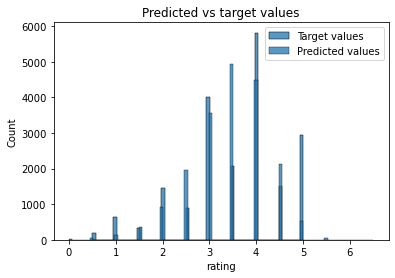

In [69]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.histplot(test['rating'],label="Target values")
sns.histplot(np.round(test['prediction']*2)/2,label = "Predicted values")
plt.title("Predicted vs target values")
plt.legend()
plt.show()

Our model can certainly be improved. We will deal now with RDD strucutures instead of dataframes to observe if there is any change in the performing of the model.